# Import Libraries and Setup
Import required libraries such as pandas, numpy, matplotlib, and seaborn. Set up notebook configurations.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Set visualization style
sns.set_theme(style="whitegrid", context="talk")

# Data Ingestion: Read Data
Load the dataset using pandas. Read from CSV or other file formats.

In [ ]:
# Load the dataset (adjust the path to your CSV file)
data_path = "enrollments_dataset.csv"
df = pd.read_csv(data_path)

# Preview the raw data
print("Raw DataFrame shape:", df.shape)
display(df.head())

# Data Cleaning and Preprocessing
Perform data cleaning by handling missing values, correcting data types, and formatting the data for analysis.

In [18]:
# --- Drop Non-Essential Columns ---
columns_to_drop = [
    "Timestamp",
    "Parent name",
    "Child Name",
    "Class ID",
    "ID for sequential classes",
    "Class Part Number",
    "Unnamed: 35",
    "Unnamed: 36",
    "Unnamed: 37",
    "Communication Preference",
    "Source",
    "Source details",
    "Concepts",
    "Interesting",
    "Another class",
    "Score - Concept",
    "Score - Interesting",
    "Score - Another class",
    "Yes",
    "Maybe",
    "No",
    "Want another slot",
    "Country",
    "Region",
    "City",  # These might be dropped here; see later block for mapping
]
df.drop(columns=columns_to_drop, inplace=True, errors="ignore")

# --- Convert 'Date' to datetime ---
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# --- Convert Time Columns ---
# Assuming times are in format '10:00 AM'
df["Start time (in PST)"] = pd.to_datetime(
    df["Start time (in PST)"], format="%I:%M %p", errors="coerce"
)
df["End time (in PST)"] = pd.to_datetime(
    df["End time (in PST)"], format="%I:%M %p", errors="coerce"
)

# --- Clean and Impute 'Age' ---
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
median_age = df["Age"].median()
df["Age"].fillna(median_age, inplace=True)
# Keep only ages between 5 and 20 (adjust if needed)
df = df[(df["Age"] >= 5) & (df["Age"] <= 20)]

print("Data shape after cleaning Age and dropping columns:", df.shape)


Data shape after cleaning Age and dropping columns: (6483, 13)


# Exploratory Data Analysis
Generate summary statistics and perform initial analyses to understand trends and distributions in the data.

In [19]:
# Impute missing 'Timezone' with the mode or default to EST if mode is not computable
if df["Timezone"].mode().size > 0:
    mode_timezone = df["Timezone"].mode()[0]
else:
    mode_timezone = "EST"
df["Timezone"].fillna(mode_timezone, inplace=True)

# If the original dataset had 'Country', you might re-read it or merge it back for mapping.
# For illustration, suppose we re-load the original dataset to use the 'Country' column:
original_df = pd.read_csv(data_path)
if "Country" in original_df.columns:
    country_timezone_mapping = {
        "United States": "EST",
        "USA": "EST",
        "US": "EST",
        "India": "IST",
        "United Kingdom": "GMT",
        "UK": "GMT",
        "Australia": "AEDT",
        # Add more mappings as needed...
    }
    # Map missing Timezone values using Country info if available
    df["Timezone"] = original_df.apply(
        lambda row: country_timezone_mapping.get(
            row["Country"], row.get("Timezone", np.nan)
        )
        if pd.isna(row.get("Timezone", np.nan))
        else row.get("Timezone", np.nan),
        axis=1,
    )
    # Fill any remaining missing values with "EST"
    df["Timezone"] = df["Timezone"].fillna("EST")

# Final cleaning: only keep valid timezones (extend the valid list as needed)
valid_timezones = {
    "EST",
    "PST",
    "MST",
    "CST",
    "IST",
    "GMT",
    "AEDT",
    "JST",
    "WAT",
    "AST",
    "PKT",
    "KST",
    "HKT",
    "SAST",
    "AEST",
    "AWST",
    "NZDT",
    "EAT",
    "EET",
    "IDT",
    "CET",
}
df["Timezone"] = df["Timezone"].apply(lambda tz: tz if tz in valid_timezones else "EST")

print("Timezone distribution after cleaning:")
print(df["Timezone"].value_counts())


Timezone distribution after cleaning:
Timezone
EST     3120
PST      927
MST      783
CST      722
IST      439
GMT      140
AEDT      72
JST       59
WAT       40
AST       39
PKT       35
KST       19
HKT       18
SAST      15
AEST      14
AWST      12
NZDT      11
EAT        8
IDT        4
EET        4
CET        2
Name: count, dtype: int64


In [20]:
# Define key columns critical to analysis
critical_cols = [
    "Attended?",
    "Final score",
    "Start time (in PST)",
    "Day",
    "Teacher Name",
    "Topics",
]
df.dropna(subset=critical_cols, inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

print("Shape after dropping rows with critical missing values:", df.shape)
print("Preview of cleaned DataFrame:")
print(df.head())


Shape after dropping rows with critical missing values: (4484, 13)
Preview of cleaned DataFrame:
    Age       Teacher Name     Type  \
0   9.0  Clark Vandeventer  Onetime   
1   9.0     Nicole Pauling  Onetime   
2   7.0      Bill Thompson  Onetime   
3   7.0  Clark Vandeventer  Onetime   
4  13.0  Clark Vandeventer  Onetime   

                                          Class name Date        Day  \
0          Travel the World with Mr. Clark : England  NaT     Monday   
1  Forgotten History: Mysteries and Extraordinary...  NaT     Monday   
2                 Public Speaking & Debate - Level 1  NaT  Wednesday   
3            Travel the World with Mr. Clark : India  NaT    Tuesday   
4  How is the President of the United States elec...  NaT   Thursday   

  Start time (in PST)   End time (in PST) Timezone Phase Mapping       Topics  \
0 1900-01-01 14:00:00 1900-01-01 15:00:00      PST       Phase 1  Life skills   
1 1900-01-01 17:00:00 1900-01-01 18:00:00      PST       Phase 1      His

# Data Visualization: Charts and Graphs
Create visualizations like line charts, bar charts, scatter plots, and histograms using matplotlib and seaborn to illustrate data trends.

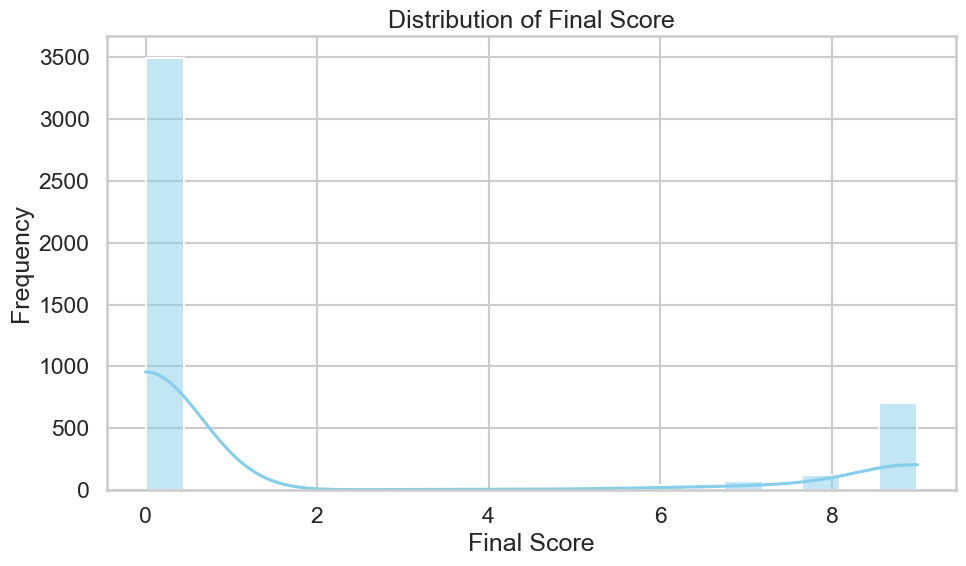

Attendance by Day:


Attended?,Class cancelled,Duplicate entry,Extra lisiting,No,No data,Not Applicable,Unenrolled,Yes
Day,,,,,,,,
Friday,NaN,0.064953,NaN,0.500677,0.004060,0.044655,0.046008,0.339648
Monday,0.003432,0.065217,0.037757,0.470252,0.002288,0.041190,0.034325,0.345538
Saturday,0.092807,0.118329,NaN,0.415313,NaN,0.083527,0.018561,0.271462
Sunday,0.093284,0.078358,NaN,0.421642,0.003731,0.104478,0.037313,0.261194
Thursday,NaN,0.073810,0.028571,0.492857,NaN,0.051190,0.045238,0.308333
Tuesday,0.020635,0.076190,NaN,0.484127,NaN,0.034921,0.026984,0.357143
Wednesday,NaN,0.056980,NaN,0.461538,NaN,0.054131,0.049858,0.377493


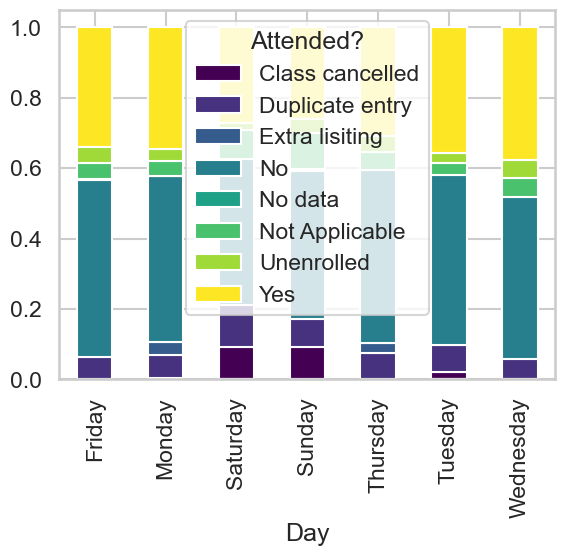

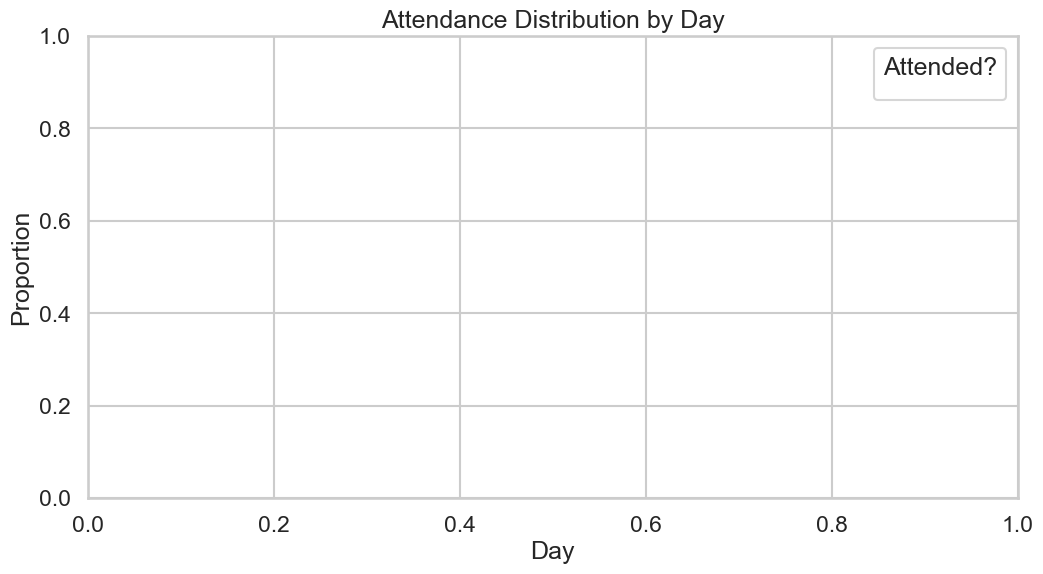

Average Final Score by Start Hour:


Start Hour
10    0.762295
11    2.198758
12    1.838835
13    1.917808
14    1.691574
15    1.662447
16    2.006459
17    2.090753
18    2.177215
Name: Final score, dtype: float64

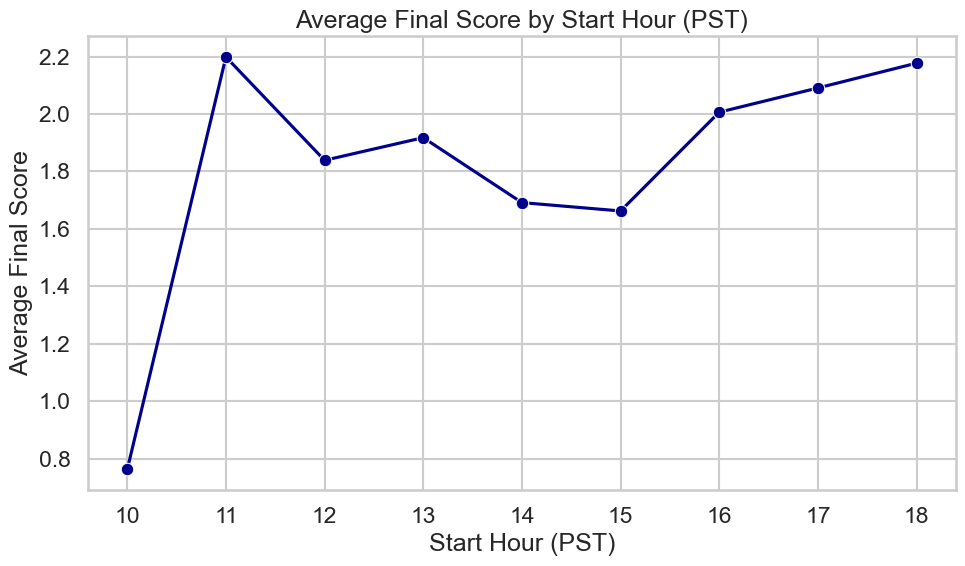

In [21]:
# Distribution of Final Score
plt.figure(figsize=(10, 6))
sns.histplot(df["Final score"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Final Score")
plt.xlabel("Final Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Attendance Distribution by Day
attendance_by_day = (
    df.groupby("Day")["Attended?"].value_counts(normalize=True).unstack()
)

print("Attendance by Day:")
display(attendance_by_day)

attendance_by_day.plot(kind="bar", stacked=True, colormap="viridis")
plt.figure(figsize=(12, 6))
plt.title("Attendance Distribution by Day")
plt.xlabel("Day")
plt.ylabel("Proportion")
plt.legend(title="Attended?")
# plt.tight_layout()
plt.show()

# Extract the start hour from time and analyze final score by hour
df["Start Hour"] = df["Start time (in PST)"].dt.hour
avg_score_by_hour = df.groupby("Start Hour")["Final score"].mean()
print("Average Final Score by Start Hour:")
display(avg_score_by_hour)
plt.figure(figsize=(10, 6))
sns.lineplot(
    x=avg_score_by_hour.index, y=avg_score_by_hour.values, marker="o", color="darkblue"
)
plt.title("Average Final Score by Start Hour (PST)")
plt.xlabel("Start Hour (PST)")
plt.ylabel("Average Final Score")
plt.xticks(avg_score_by_hour.index)
plt.tight_layout()
plt.show()


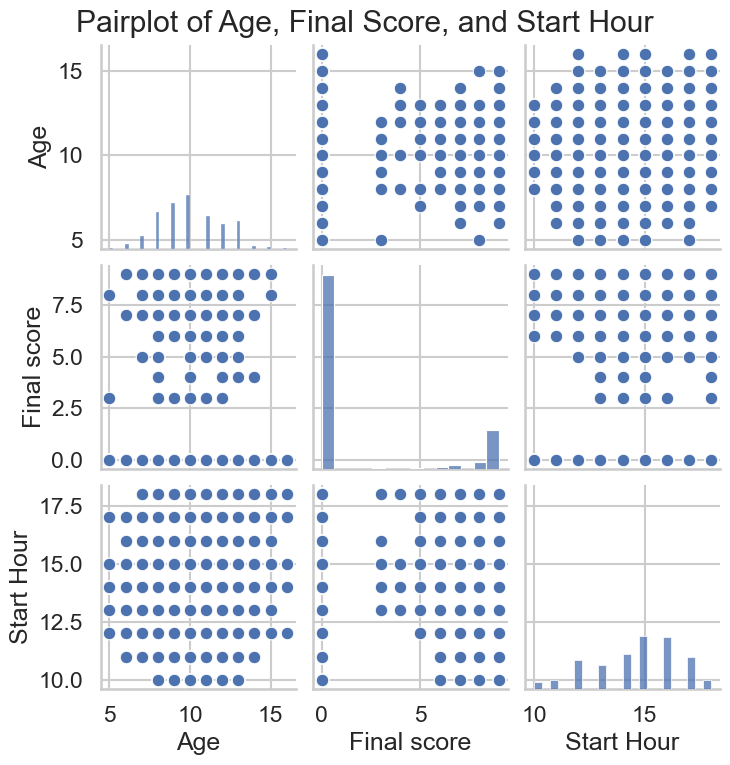

Correlation Matrix:


,Age,Final score,Start Hour
Age,1.000000,-0.004593,-0.036124
Final score,-0.004593,1.000000,0.035466
Start Hour,-0.036124,0.035466,1.000000


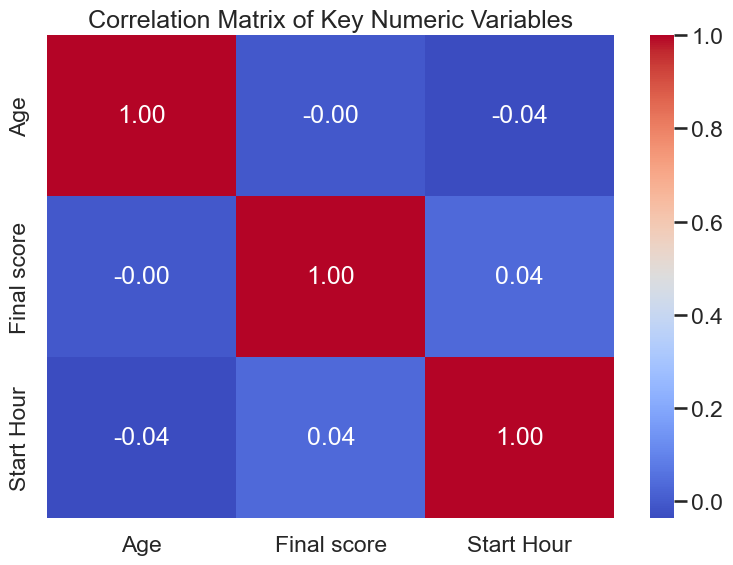

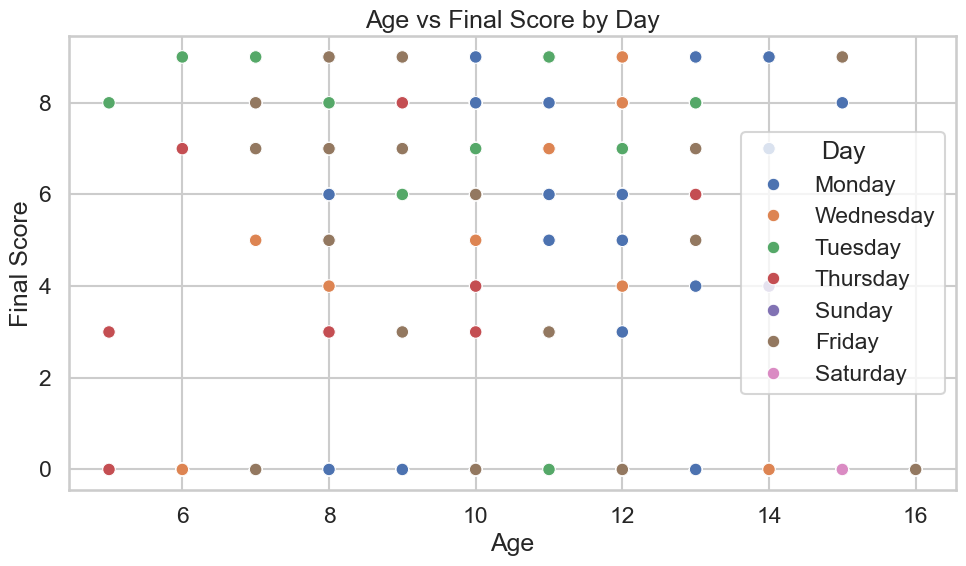

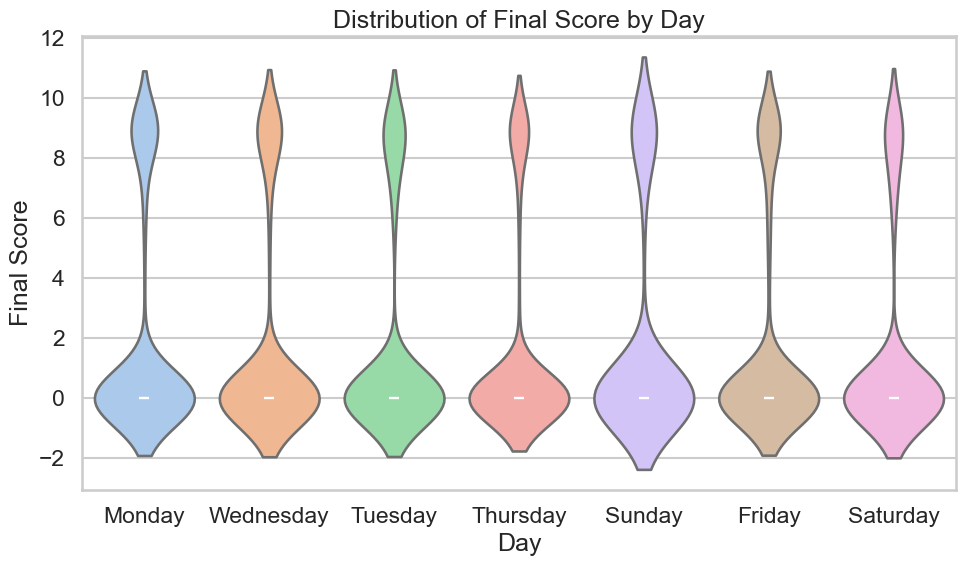

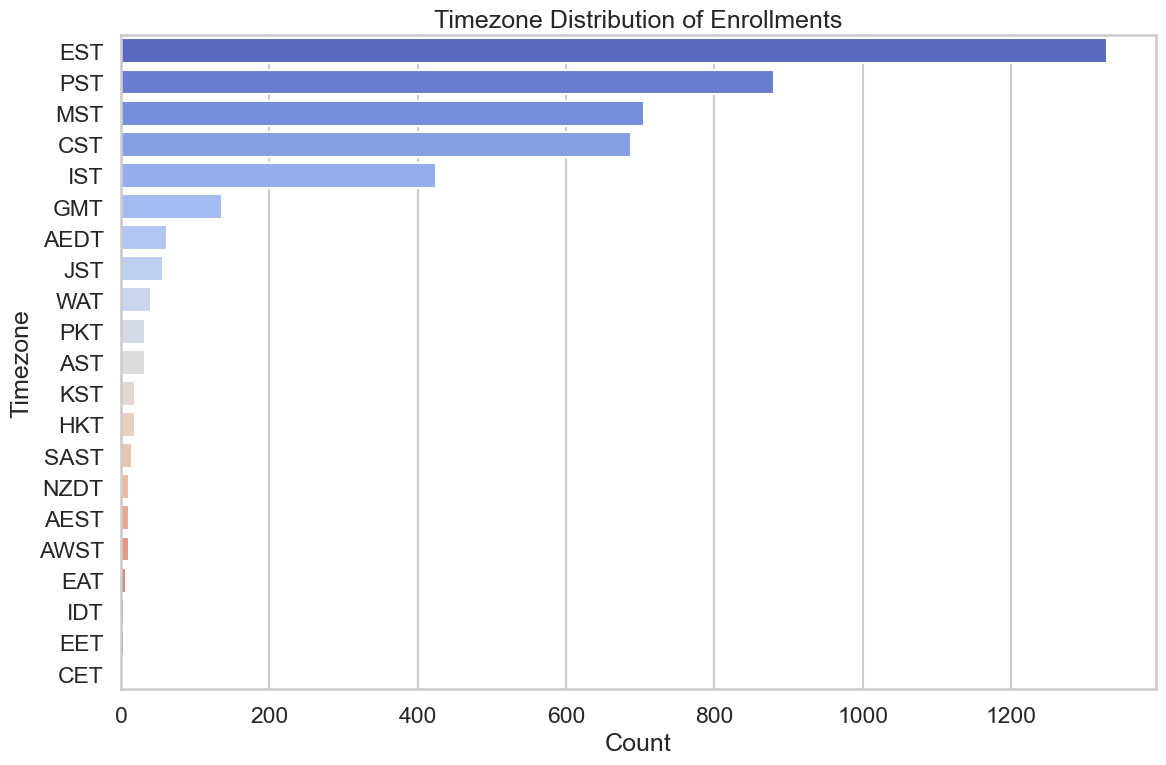

In [22]:
# Pairplot for key numeric variables
numeric_cols = ["Age", "Final score", "Start Hour"]
sns.pairplot(df[numeric_cols])
plt.suptitle("Pairplot of Age, Final Score, and Start Hour", y=1.02)
plt.show()

# Correlation Heatmap for numeric variables
corr_matrix = df[numeric_cols].corr()
print("Correlation Matrix:")
display(corr_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Key Numeric Variables")
plt.tight_layout()
plt.show()

# Scatter Plot: Age vs Final Score
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Age", y="Final score", data=df, hue="Day", palette="deep")
plt.title("Age vs Final Score by Day")
plt.xlabel("Age")
plt.ylabel("Final Score")
plt.legend(title="Day")
plt.tight_layout()
plt.show()

# Violin Plot: Final Score by Day to show distribution
plt.figure(figsize=(10, 6))
sns.violinplot(x="Day", y="Final score", data=df, palette="pastel")
plt.title("Distribution of Final Score by Day")
plt.xlabel("Day")
plt.ylabel("Final Score")
plt.tight_layout()
plt.show()

# Countplot: Distribution of Timezones
plt.figure(figsize=(12, 8))
sns.countplot(
    y="Timezone", data=df, order=df["Timezone"].value_counts().index, palette="coolwarm"
)
plt.title("Timezone Distribution of Enrollments")
plt.xlabel("Count")
plt.ylabel("Timezone")
plt.tight_layout()
plt.show()


Top 10 Teachers by Average Final Score:


Teacher Name
Mary Daniels           3.687500
Nicole Pauling         2.874317
Melissa Peterson       2.750000
Rae Wilson             2.480519
Dana Lorelle           2.466926
Marcos Del Cogliano    2.370370
Stefany Pineda         2.363636
Bill Thompson          2.352113
Keallah Smith          2.328767
Ms. Courtney           2.276923
Name: Final score, dtype: float64


Top 10 Teachers by Class Count:


Teacher Name
Aaron Potsick     348
Annalisa Ard      319
Misses Dee        276
Dana Lorelle      257
Amalia Fernand    230
Cara Bailey       216
Ms. Courtney      195
Lianne Brunt      187
Erin Coley        186
Paige Howell      184
Name: count, dtype: int64

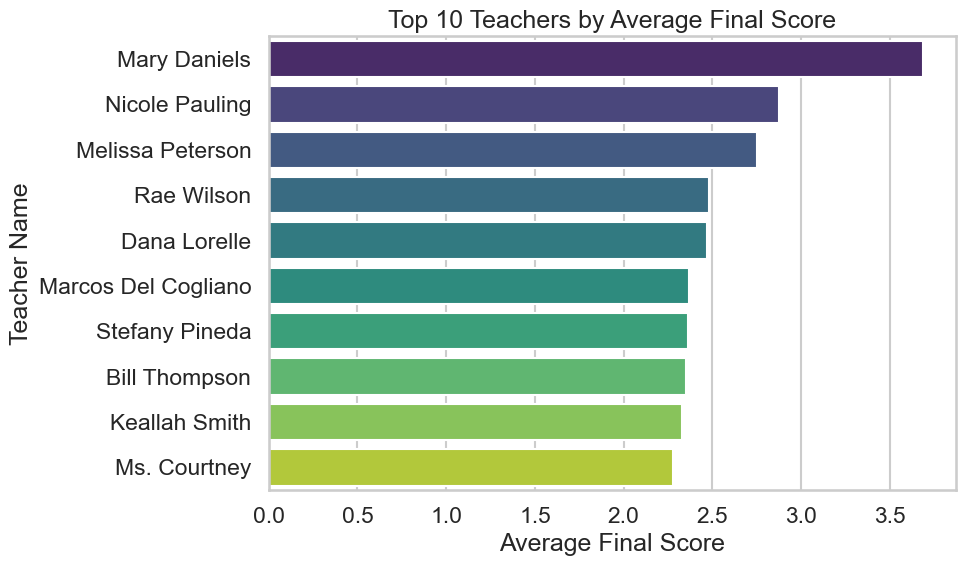

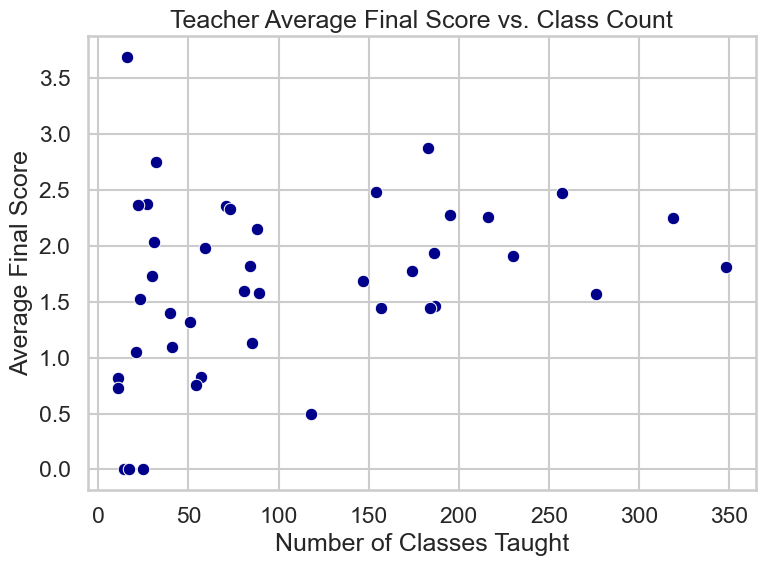

Top 10 Teacher-Topic Combinations by Final Score:


,Teacher Name,Topics,Final score
52,Mary Daniels,Math,3.687500
17,Bill Thompson,Life skills,3.400000
4,Aaron Potsick,Speaking,3.384615
54,Melissa Peterson,Life skills,3.210526
74,Stefany Pineda,Speaking,3.125000
69,Rae Wilson,Coding,3.083333
30,Erin Coley,Life skills,3.036364
50,Mariposa Enamorada,Financial Literacy,3.000000
65,Nicole Pauling,History,2.874317
63,Ms. Courtney,Social studies,2.848485


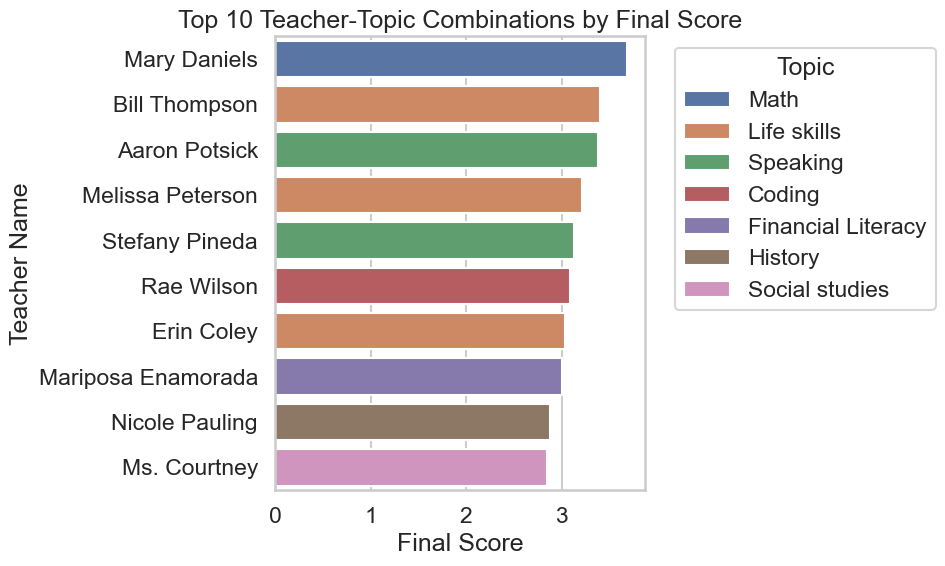

In [23]:
# Teacher Performance: Average Final Score and Class Count
teacher_scores = (
    df.groupby("Teacher Name")["Final score"].mean().sort_values(ascending=False)
)
teacher_counts = df["Teacher Name"].value_counts()

print("Top 10 Teachers by Average Final Score:")
display(teacher_scores.head(10))
print("\nTop 10 Teachers by Class Count:")
display(teacher_counts.head(10))

# Barplot: Top 10 Teachers by Average Final Score
top_teachers = teacher_scores.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_teachers.values, y=top_teachers.index, palette="viridis")
plt.title("Top 10 Teachers by Average Final Score")
plt.xlabel("Average Final Score")
plt.ylabel("Teacher Name")
plt.tight_layout()
plt.show()

# Scatter Plot: Relationship between Teacher Class Count and Average Score
teacher_df = pd.DataFrame(
    {"Average Score": teacher_scores, "Class Count": teacher_counts}
).dropna()

plt.figure(figsize=(8, 6))
sns.scatterplot(x="Class Count", y="Average Score", data=teacher_df, color="darkblue")
plt.title("Teacher Average Final Score vs. Class Count")
plt.xlabel("Number of Classes Taught")
plt.ylabel("Average Final Score")
plt.tight_layout()
plt.show()

# Teacher-Topic Performance: Which teacher-topic combinations yield the highest scores?
teacher_topic = (
    df.groupby(["Teacher Name", "Topics"])["Final score"].mean().reset_index()
)
top_teacher_topic = teacher_topic.sort_values("Final score", ascending=False).head(10)
print("Top 10 Teacher-Topic Combinations by Final Score:")
display(top_teacher_topic)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Final score",
    y="Teacher Name",
    hue="Topics",
    data=top_teacher_topic,
    dodge=False,
    palette="deep",
)
plt.title("Top 10 Teacher-Topic Combinations by Final Score")
plt.xlabel("Final Score")
plt.ylabel("Teacher Name")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Generating Insights and Recommendations
Interpret the results from the analyses and visualizations to derive actionable insights and provide recommendations.

In [24]:
# Create a DataFrame for a recommended launch week schedule
launch_schedule = pd.DataFrame(
    {
        "Day": [
            "Monday",
            "Monday",
            "Tuesday",
            "Tuesday",
            "Wednesday",
            "Wednesday",
            "Thursday",
            "Thursday",
            "Friday",
            "Friday",
            "Saturday",
            "Saturday",
            "Sunday",
            "Sunday",
        ],
        "Start Time (PST)": [
            "11:00",
            "17:00",
            "11:00",
            "17:00",
            "11:00",
            "17:00",
            "11:00",
            "17:00",
            "11:00",
            "17:00",
            "11:00",
            "17:00",
            "11:00",
            "17:00",
        ],
        "Teacher Name": [
            "Mary Daniels",  # Example: best Math teacher on Monday 11:00
            "Melissa Peterson",  # Monday 17:00
            "Aaron Potsick",  # Tuesday 11:00
            "Rae Wilson",  # Tuesday 17:00
            "Stefany Pineda",  # Wednesday 11:00
            "Bill Thompson",  # Wednesday 17:00
            "Nicole Pauling",  # Thursday 11:00
            "Ms. Courtney",  # Thursday 17:00
            "Mariposa Enamorada",  # Friday 11:00
            "Erin Coley",  # Friday 17:00
            "Popular Session*",  # Saturday 11:00
            "Interactive Q&A*",  # Saturday 17:00
            "Recap Session*",  # Sunday 11:00
            "Guest Panel*",  # Sunday 17:00
        ],
        "Topic": [
            "Math",  # Monday 11:00 – highest rated Math session
            "Life skills",  # Monday 17:00 – consistently strong feedback
            "Speaking",  # Tuesday 11:00
            "Coding",  # Tuesday 17:00
            "Speaking",  # Wednesday 11:00
            "Life skills",  # Wednesday 17:00
            "History",  # Thursday 11:00
            "Social studies",  # Thursday 17:00
            "Financial Literacy",  # Friday 11:00
            "Life skills",  # Friday 17:00
            "Repeat Popular Class",  # Saturday 11:00
            "Open Q&A Session",  # Saturday 17:00
            "Learning Recap",  # Sunday 11:00
            "Expert Guest Panel",  # Sunday 17:00
        ],
        "Avg Final Score": [
            3.69,
            3.05,
            3.38,
            3.08,
            3.13,
            3.40,
            2.86,
            2.85,
            3.00,
            3.04,
            None,
            None,
            None,
            None,
        ],
        "Comments": [
            "Highest rated Math session; very engaging.",
            "Excellent Life skills class; consistent performance.",
            "Dynamic speaking session; high engagement.",
            "Effective Coding session; interactive and fun.",
            "Strong Speaking performance; energizing session.",
            "Very engaging Life skills session; high feedback.",
            "Well-received History class; informative.",
            "Effective Social studies session; solid delivery.",
            "Top in Financial Literacy; engaging and clear.",
            "Consistent Life skills performance; reliable quality.",
            "Repeat of popular session for newcomers.",
            "Interactive Q&A to foster community.",
            "Recap session to consolidate key learnings.",
            "Expert panel discussion to close the week.",
        ],
    }
)

print("Final Recommended Launch Week Timetable:")
display(launch_schedule)


Final Recommended Launch Week Timetable:


,Day,Start Time (PST),Teacher Name,Topic,Avg Final Score,Comments
0,Monday,11:00,Mary Daniels,Math,3.69,Highest rated Math session; very engaging.
1,Monday,17:00,Melissa Peterson,Life skills,3.05,Excellent Life skills class; consistent perfor...
2,Tuesday,11:00,Aaron Potsick,Speaking,3.38,Dynamic speaking session; high engagement.
3,Tuesday,17:00,Rae Wilson,Coding,3.08,Effective Coding session; interactive and fun.
4,Wednesday,11:00,Stefany Pineda,Speaking,3.13,Strong Speaking performance; energizing session.
5,Wednesday,17:00,Bill Thompson,Life skills,3.40,Very engaging Life skills session; high feedback.
6,Thursday,11:00,Nicole Pauling,History,2.86,Well-received History class; informative.
7,Thursday,17:00,Ms. Courtney,Social studies,2.85,Effective Social studies session; solid delivery.
8,Friday,11:00,Mariposa Enamorada,Financial Literacy,3.00,Top in Financial Literacy; engaging and clear.
9,Friday,17:00,Erin Coley,Life skills,3.04,Consistent Life skills performance; reliable q...
